TO_DO:
* build final model with fe and p
* calculate true coefficients
* plot learning curve 

In [1]:
#import libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report
import statsmodels.api as sm
SEED = 23

In [2]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

In [3]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    return ratio, df_win

In [4]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.

    Example:
    --------
    >>> high_corr(df)
    Removing A with 0.95th percentile = 1.0
    Remaining columns: Index(['B', 'C'], dtype='object')
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate mean correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]

    print("Remaining columns:", df.columns)
    return df

In [5]:
def grid_log_c(X_train, y_train, X_test, y_test, C_values, penalty='l1', solver = 'liblinear', random_state=23):
    """
    Evaluates and plots the train and test accuracy of a logistic regression model for various C values.

    Parameters:
    -----------
    X_train : array-like or DataFrame
        The features for the training set.
    y_train : array-like or DataFrame
        The target variable for the training set.
    X_test : array-like or DataFrame
        The features for the test set.
    y_test : array-like or DataFrame
        The target variable for the test set.
    C_values : list of floats
        The list of C values to evaluate. C is the inverse regularization strength.
    penalty : str, optional
        The penalty type to use in the logistic regression model ('l1' or 'l2'). Default is 'l1'.
    solver: str, optional
        Algorithm to use in the optimization problem. Default is ‘liblinear’.
    random_state : int, optional
        The number used to initialize a pseudorandom number generator, which is used for reproducibility of the results.

    Returns:
    --------
    train_accuracies : list of floats
        The train accuracies for the different C values.
    test_accuracies : list of floats
        The test accuracies for the different C values.
    
    Notes:
    ------
    - This function uses a log scale for the C values on the x-axis of the plot.

    Example:
    --------
    >>> C_values = [0.001, 0.01, 0.1, 1, 10]
    >>> grid_log_c(X_train, y_train, X_test, y_test, C_values, 32)

    """
    train_accuracies = []
    test_accuracies = []

    # Implement a model
    for c in C_values:
        lr = LogisticRegression(C=c, solver=solver, penalty=penalty, random_state=random_state)
        lr.fit(X_train, y_train)

        train_accuracy = lr.score(X_train, y_train)
        test_accuracy = lr.score(X_test, y_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    # Draw a plot
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='^')
    plt.xscale('log')
    plt.xlabel('C Value (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy for Different C Values')
    plt.legend()
    plt.show()

    return train_accuracies, test_accuracies

In [6]:
def plot_grid_search(cv_results, grid_params):
    """
    Plots the test scores from a Grid Search as either a line plot or heatmap based on the number of hyperparameters.

    Parameters:
    -----------
    cv_results : dict
        A dictionary of cross-validation results, usually obtained from `GridSearchCV.cv_results_`.
    
    grid_params : list of str
        A list of hyperparameter names that are part of the grid search.

    Returns:
    --------
    None

    Notes:
    ------
    - If there's only one hyperparameter, the function will plot a line plot.
    - If there are two hyperparameters, the function will plot a heatmap.
    - If there are more than two hyperparameters, the function will print a message indicating its limitation.
    
    Example:
    --------
    >>> plot_grid_search(cv_results, ['param1', 'param2'])
    [Heatmap is displayed]

    >>> plot_grid_search(cv_results, ['param1'])
    [Line plot is displayed]
    """
    #Convert to DataFrame
    results = pd.DataFrame(cv_results)

    # If only one hyperparameter, plot a line plot
    if len(grid_params) == 1:
        param = 'param_' + grid_params[0]
        plt.figure(figsize=(8, 6))
        plt.plot(results[param], results['mean_test_score'], marker='o')
        plt.xlabel(grid_params[0])
        plt.ylabel('Mean Test Score')
        plt.title(f"Grid Search Test Scores")
        plt.show()
    
    # If two hyperparameters, plot a heatmap
    elif len(grid_params) == 2:
        pivot_table = results.pivot(index=f'param_{grid_params[0]}', 
                                    columns=f'param_{grid_params[1]}', 
                                    values='mean_test_score')
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
        plt.xlabel(grid_params[1])
        plt.ylabel(grid_params[0])
        plt.title(f"Grid Search Test Score Heatmap")
        plt.show()

    # For more than two hyperparameters, print a message
    else:
        print("The function is designed to plot up to two hyperparameters.")

In [7]:
def feature_importance_logreg(logistic_model, cut_off=None):
    """
    Plots feature importances for a logistic regression model using L1 regularisation.

    Parameters:
    ----------
    logistic_model : sklearn.linear_model object
        The logistic regression model.

    cut_off : float, optional
        The cut-off value to consider for feature importance.

    Returns:
    -------
    feature_df : pandas DataFrame
        A DataFrame containing the features sorted by their importance.
        
    omitted_df : pandas DataFrame
        A DataFrame containing the features that were omitted based on the cut-off value.
    """
    # Get feature importances
    feature_importance_values = np.abs(logistic_model.coef_)
    
    # Sort feature importances
    indices = np.argsort(feature_importance_values[0])[::-1]
    
    sorted_feature_names = [X_train.columns[i] for i in indices]
    sorted_importance_values = [feature_importance_values[0][i] for i in indices]
    
    # Apply cutoff if specified
    if cut_off is not None:
        omitted_feature_names = [name for i, name in enumerate(sorted_feature_names) if sorted_importance_values[i] < cut_off]
        omitted_importance_values = [value for value in sorted_importance_values if value < cut_off]
        
        sorted_feature_names = [name for name in sorted_feature_names if name not in omitted_feature_names]
        sorted_importance_values = [value for value in sorted_importance_values if value >= cut_off]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance (Logistic Regression)")
    plt.bar(range(len(sorted_importance_values)), sorted_importance_values, align="center")
    plt.xticks(range(len(sorted_importance_values)), sorted_feature_names, rotation=90)  # Add rotation for better visibility
    plt.xlabel("Feature Name")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()
    
    # Create a DataFrame for sorted feature importances
    feature_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importance_values
    })
    
    # Create a DataFrame for omitted feature importances
    omitted_df = pd.DataFrame({
        'Omitted Feature': omitted_feature_names,
        'Omitted Importance': omitted_importance_values
    })
    
    return feature_df, omitted_df

In [8]:
def plot_roc(X_train, y_train, classifier, n_splits):
    """
    Plots the Receiver Operating Characteristic (ROC) curve using Stratified K-Fold cross-validation.

    Parameters:
    -----------
    X_train : pandas DataFrame
        The feature matrix for the training set.
    y_train : pandas Series
        The target vector for the training set.
    classifier : scikit-learn classifier object
        A fitted classifier that has a `predict_proba` method.
    n_splits : int
        The number of folds for Stratified K-Fold cross-validation.

    Returns:
    --------
    [The ROC curves from each fold as well as the mean and +/- 1 std. dev. are plotted.]

    Notes:
    ------
    - The AUC (Area Under the Curve) for each fold is also displayed.
    """
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
        classifier.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])  # Use iloc for DataFrame

        # Compute ROC values
        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], classifier.predict_proba(X_train.iloc[test_idx])[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

In [9]:
def plot_omitted_accuracy(X_train_smote, y_train_smote, X_test_final, y_test, high_pvalues, low_imp_df, SEED=42):
    """
    Plots the train and test accuracy of a Logistic Regression model when omitting certain variables.
    Performs this operation with and without replacement.

    Parameters:
    -----------
    X_train_smote, y_train_smote : Training data and labels
    X_test_final, y_test : Test data and labels
    high_pvalues : list of features to be omitted based on high p-values
    low_imp_df : DataFrame containing features to be omitted based on low importance
    SEED : random state seed for reproducibility

    Returns:
    --------
    acc_df : DataFrame containing train and test accuracies

    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 6))

    # Omitting variables with replacement
    to_delete = set(high_pvalues + low_imp_df['Omitted Feature'].to_list())
    acc_dict = {}
    for var in to_delete:
        X_train_fe = X_train_smote.copy()
        X_train_fe.drop(columns=var, inplace=True)
        log = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000, random_state=SEED)
        log.fit(X_train_fe, y_train_smote)
        train_score = log.score(X_train_fe, y_train_smote)
        y_pred_fe = log.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    acc_df.plot(ax=axs[0], title='With Replacement')
    axs[0].set_xticks(np.arange(len(acc_df.index)))
    axs[0].set_xticklabels(acc_df.index, rotation=90)

    # Omitting variables without replacement
    to_delete = list(acc_df.sort_values('test_acc', ascending=False).index)
    acc_dict = {}
    X_train_fe = X_train_smote.copy()
    for var in to_delete:
        X_train_fe.drop(columns=var, inplace=True)
        log = LogisticRegression(max_iter=1000, random_state=SEED)
        log.fit(X_train_fe, y_train_smote)
        train_score = log.score(X_train_fe, y_train_smote)
        y_pred_fe = log.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    acc_df.plot(ax=axs[1], title='Without Replacement')
    axs[1].set_xticks(np.arange(len(acc_df.index)))
    axs[1].set_xticklabels(acc_df.index, rotation=90)
    plt.show()
    
    #Creating the list of omitted variables
    acc_delete = []
    for var in acc_df.index:
        acc_delete.append(var)
        if acc_df['test_acc'].idxmax() in acc_delete:
            break

    return acc_df, acc_delete

# Data import and transformation

In [10]:
#load the data

df = pd.read_csv('D:/Extra study/datasets/taiwanese+bankruptcy+prediction/data.csv')

In [11]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [13]:
#check the types

print(df.dtypes.value_counts())

float64    93
int64       3
Name: count, dtype: int64


In [14]:
#check the nulls

df.isnull().any().any()

False

In [15]:
#basic statistics

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [16]:
df['Bankrupt?'].value_counts(normalize = True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [17]:
num_cols = df.select_dtypes(include=['float64']).columns

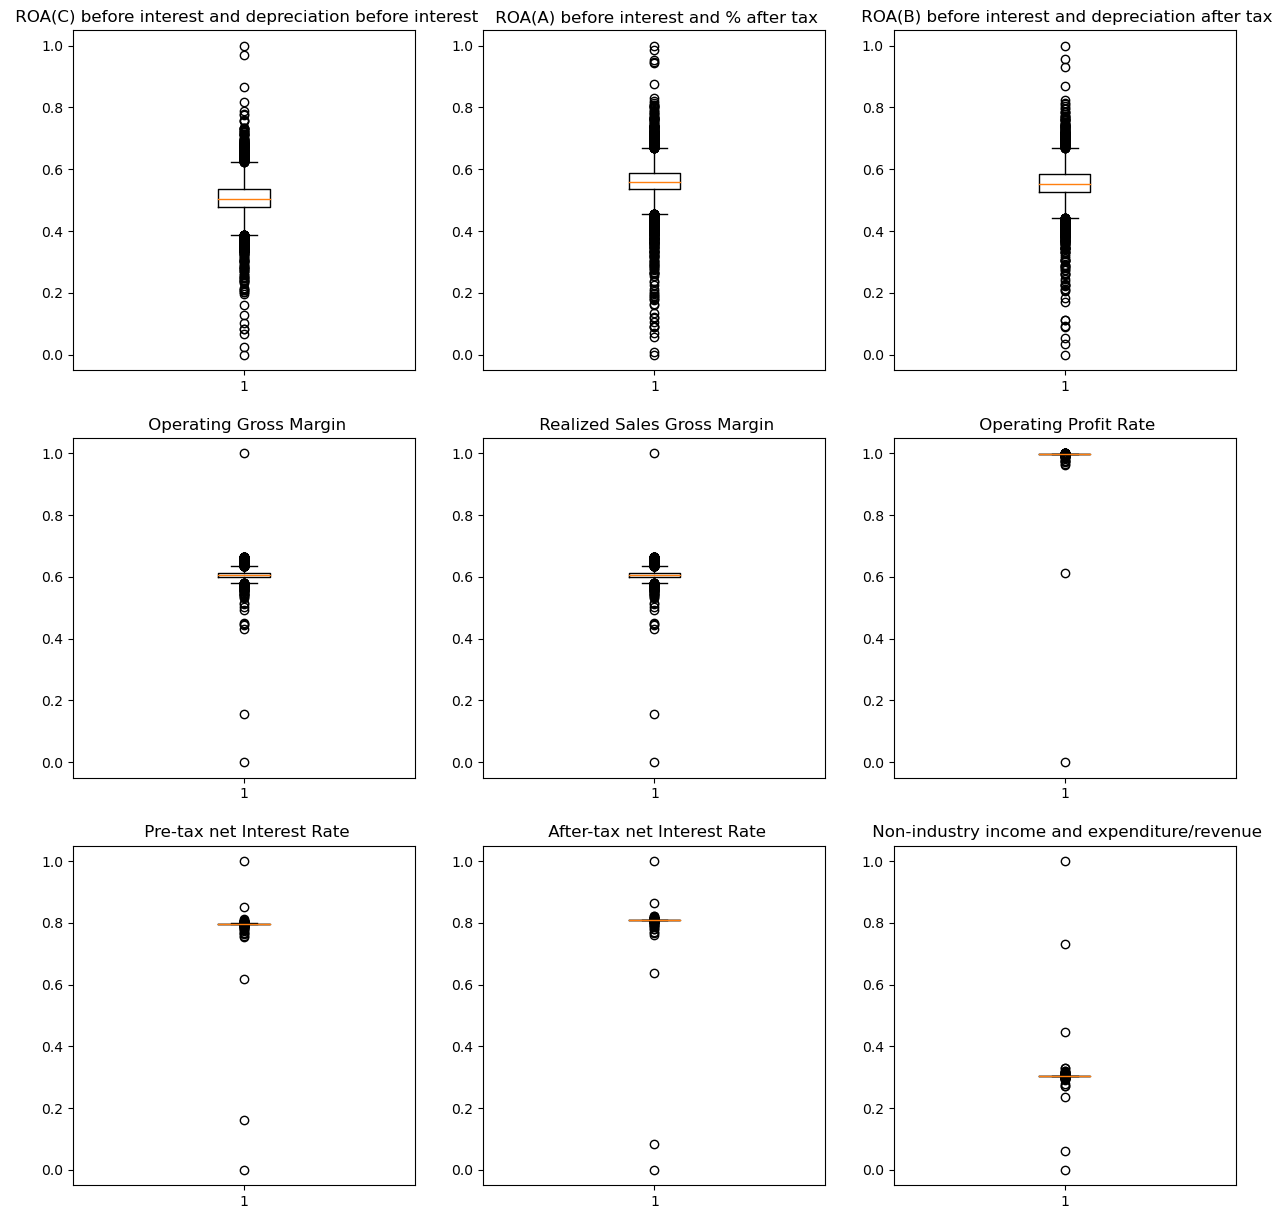

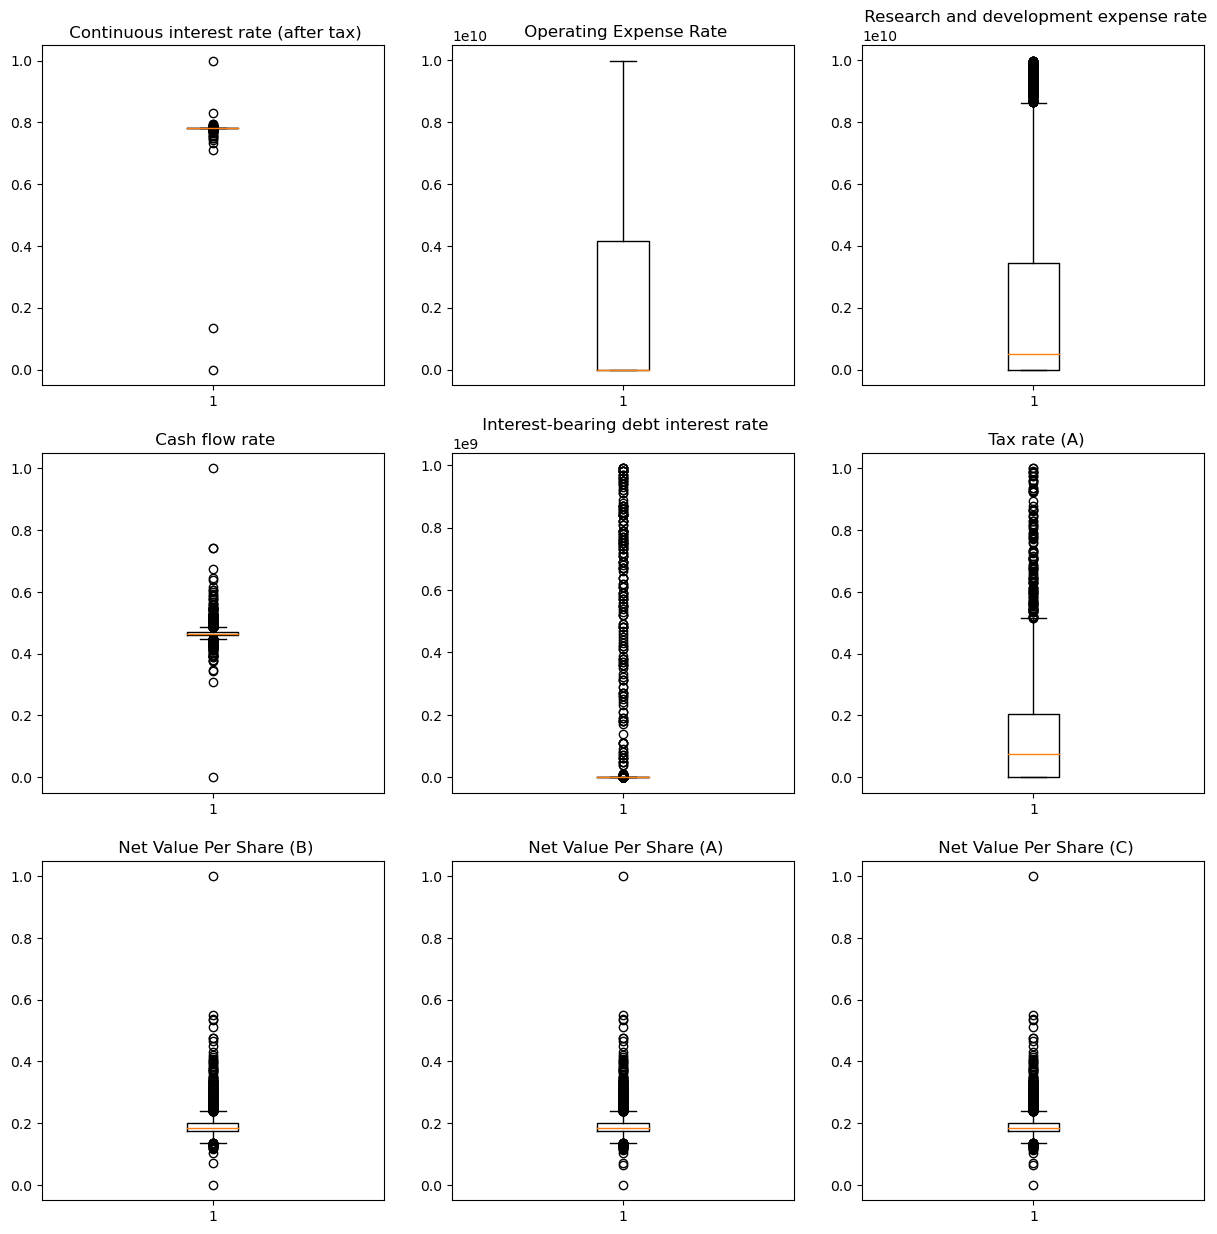

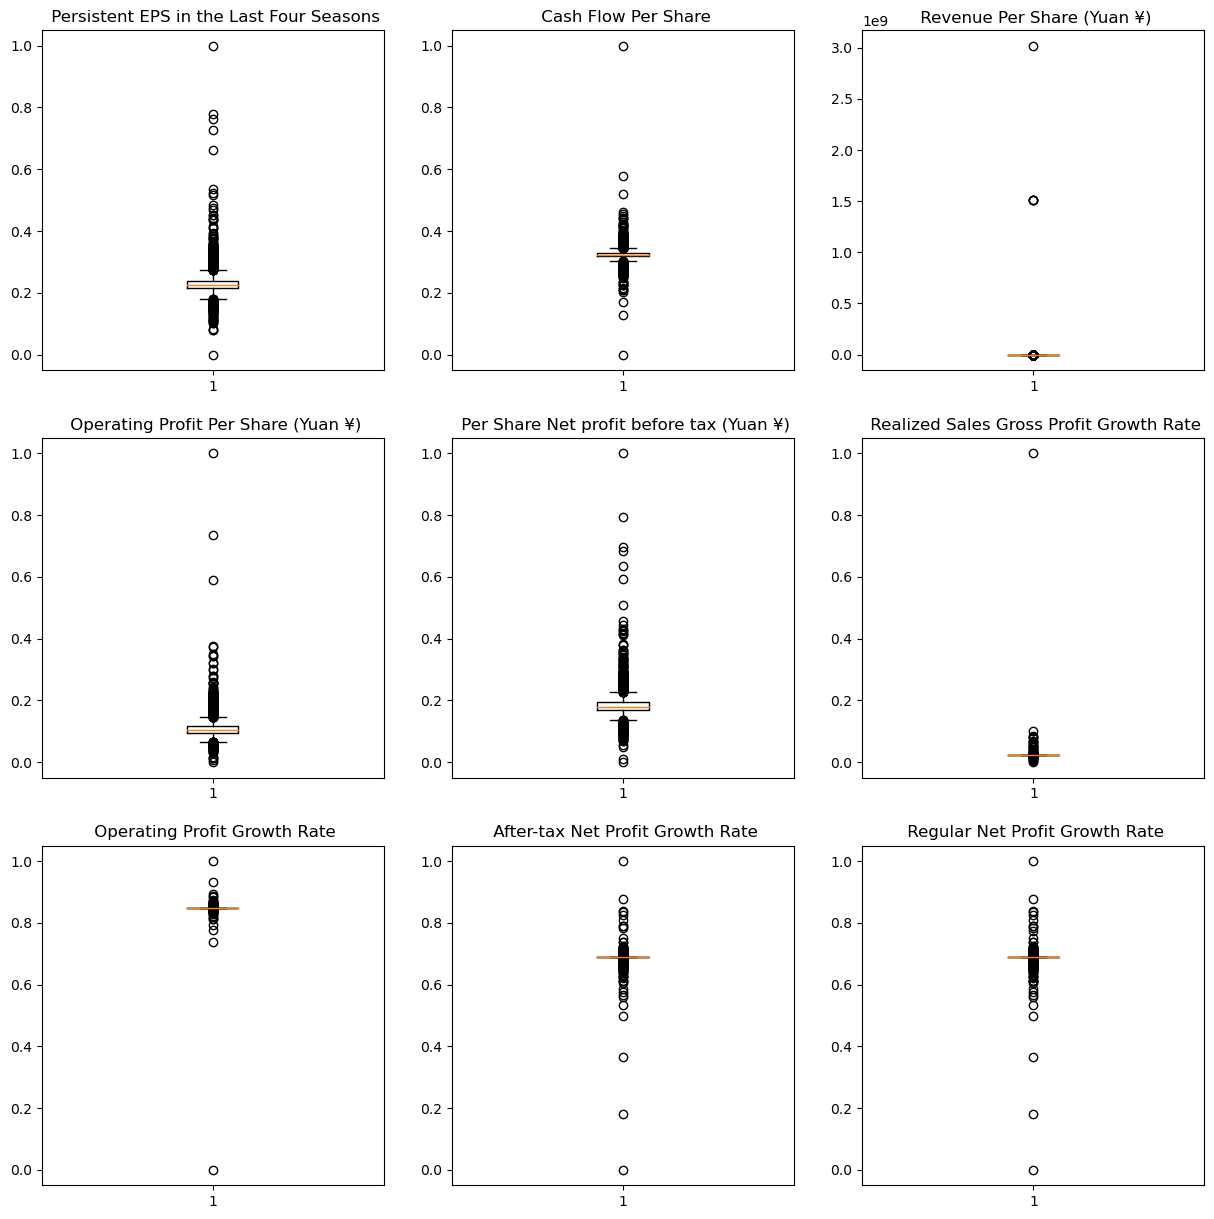

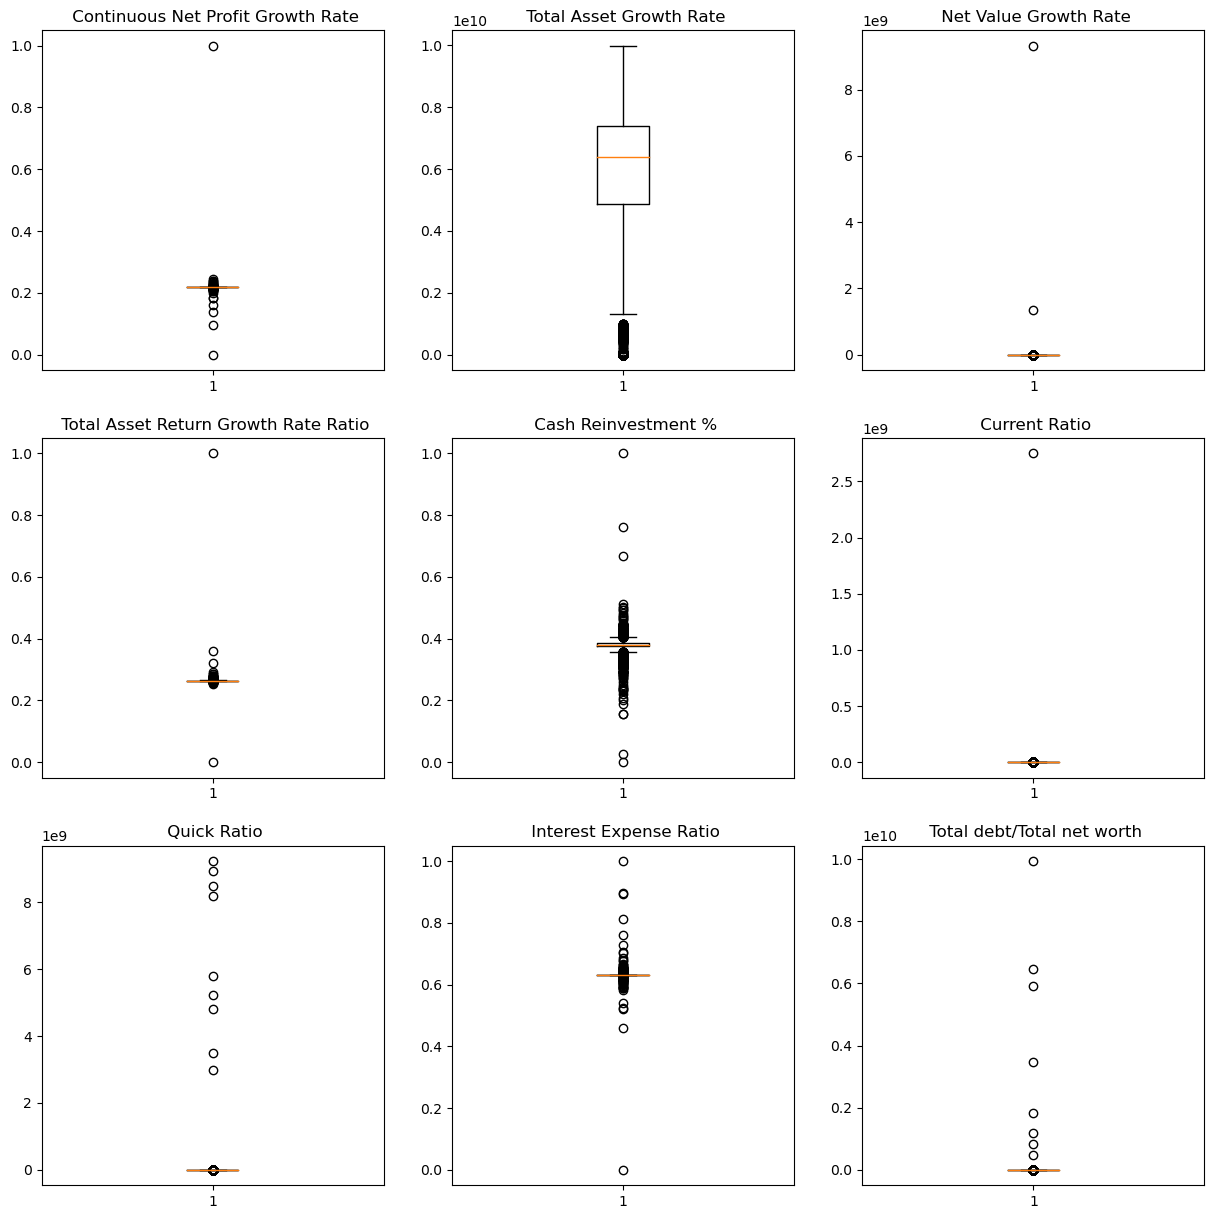

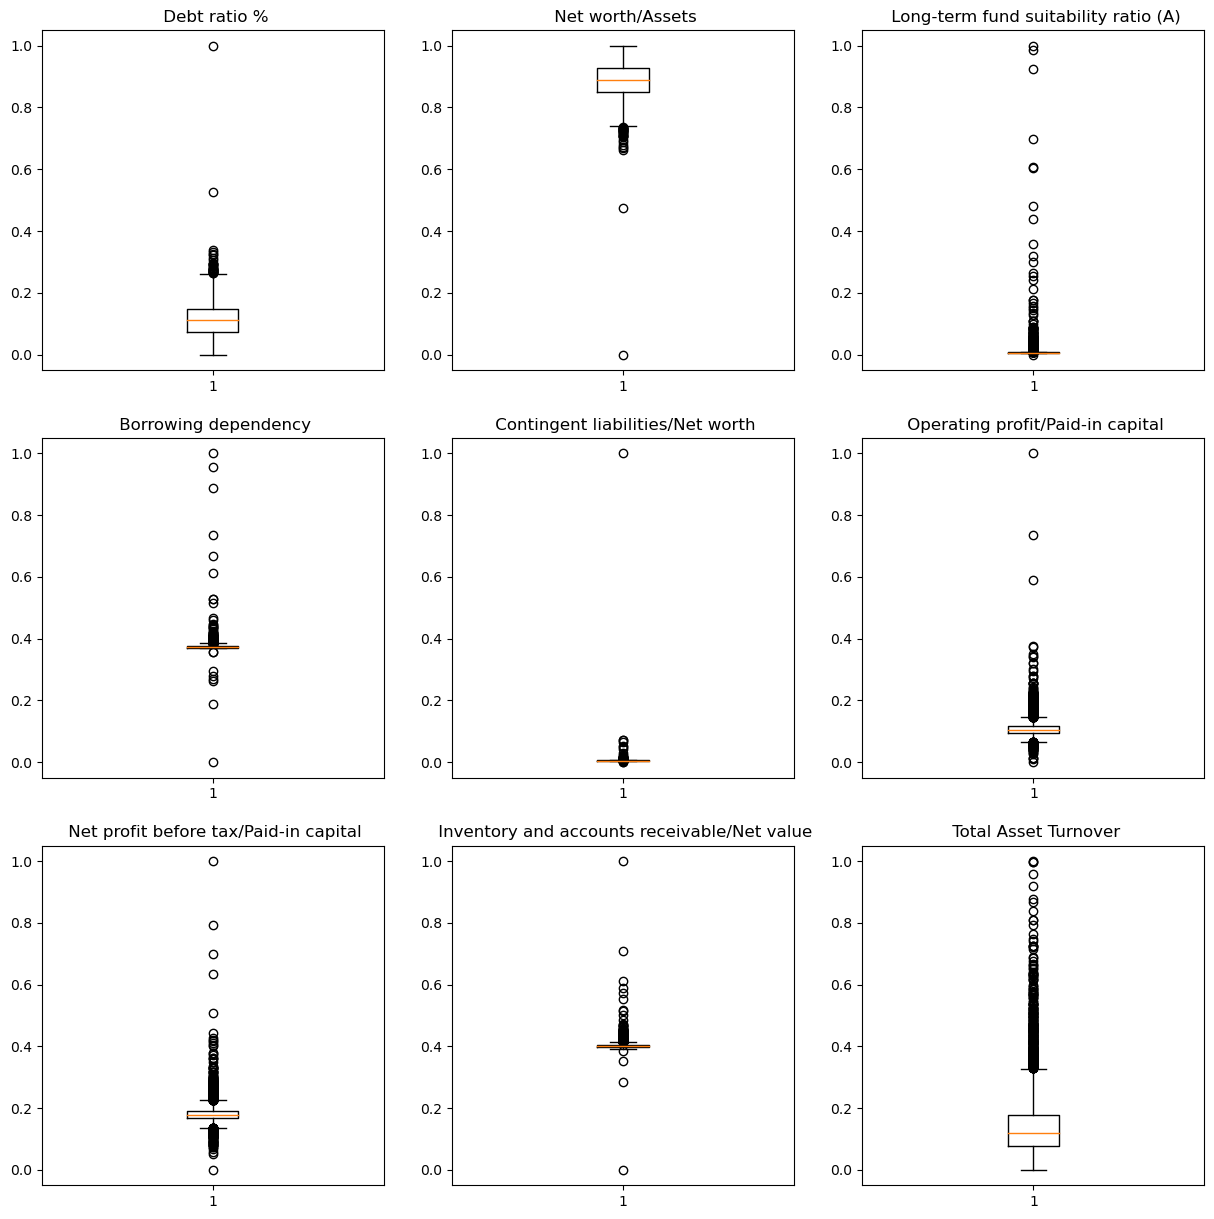

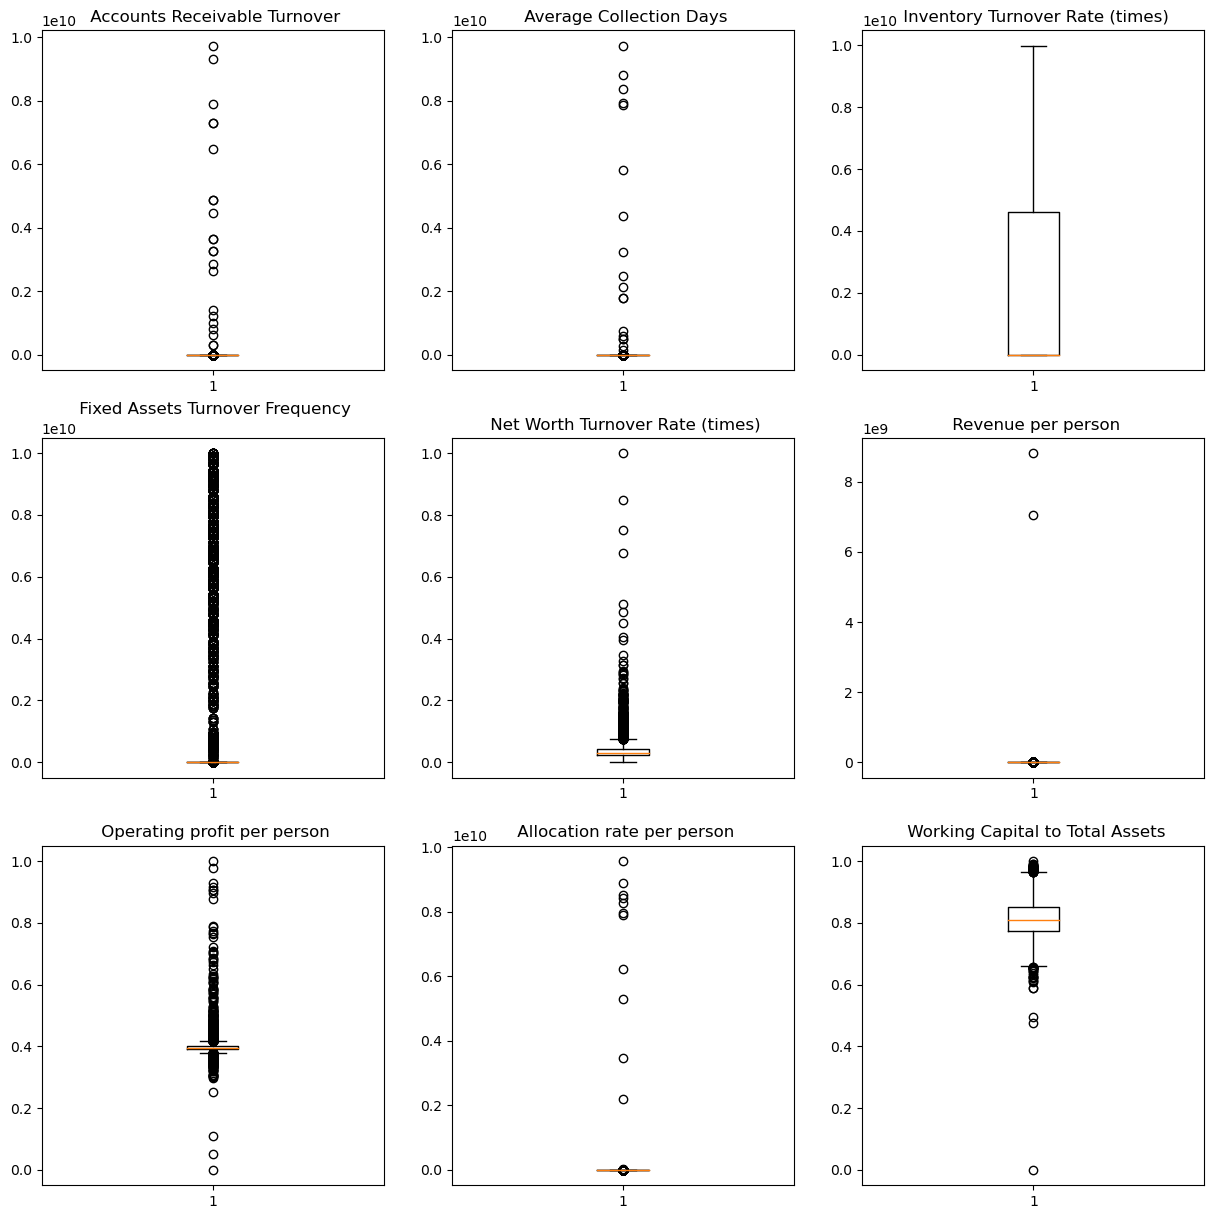

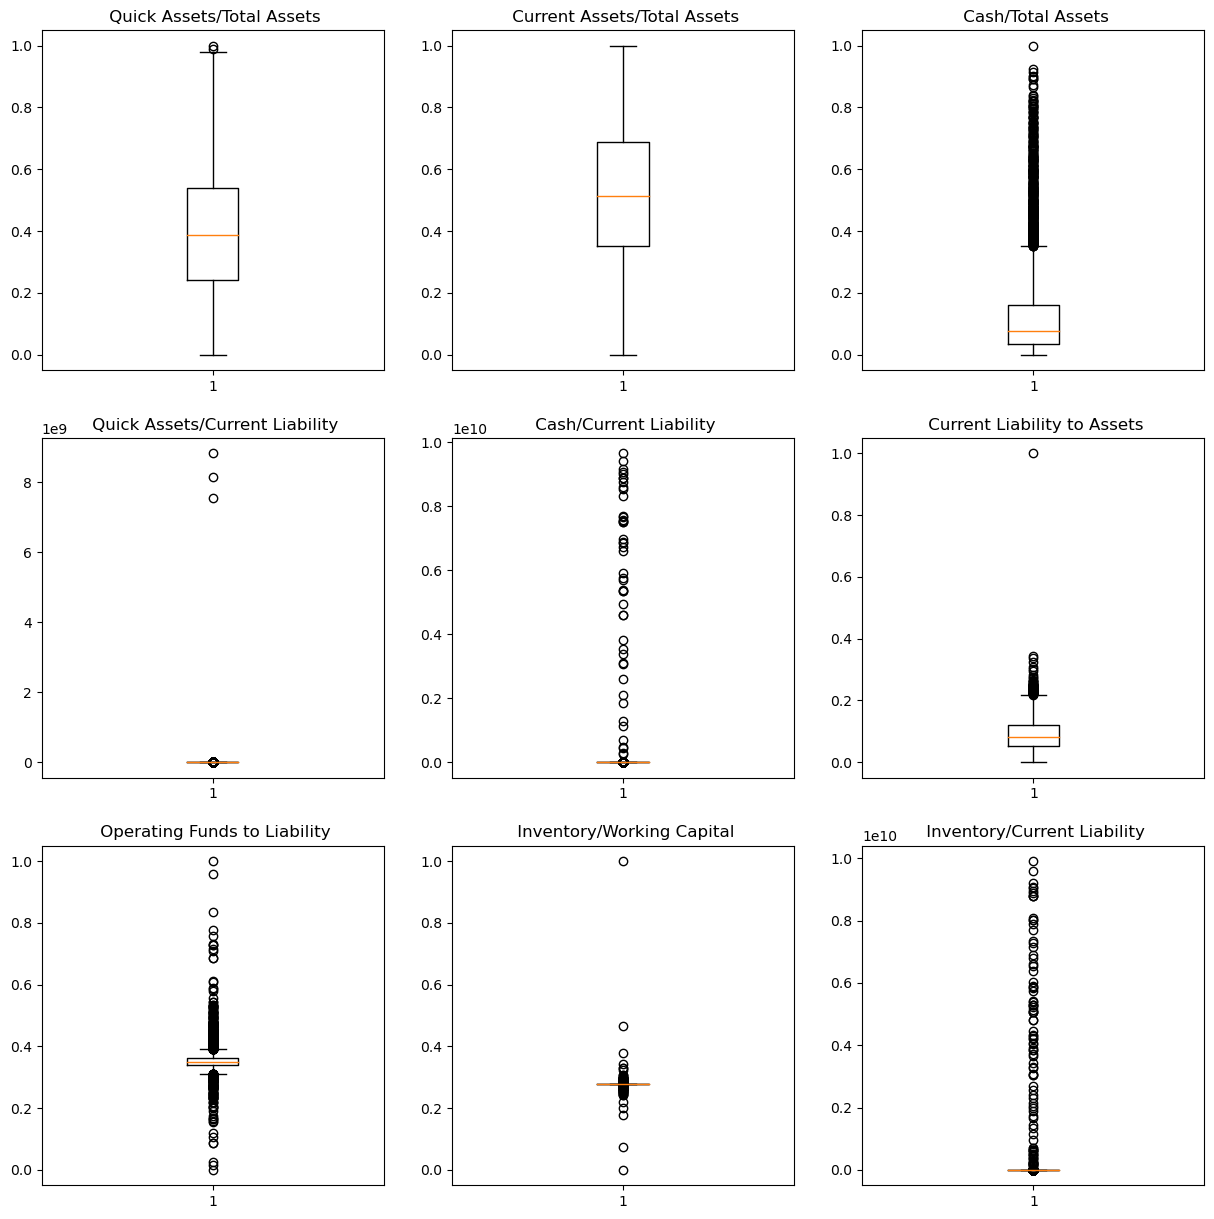

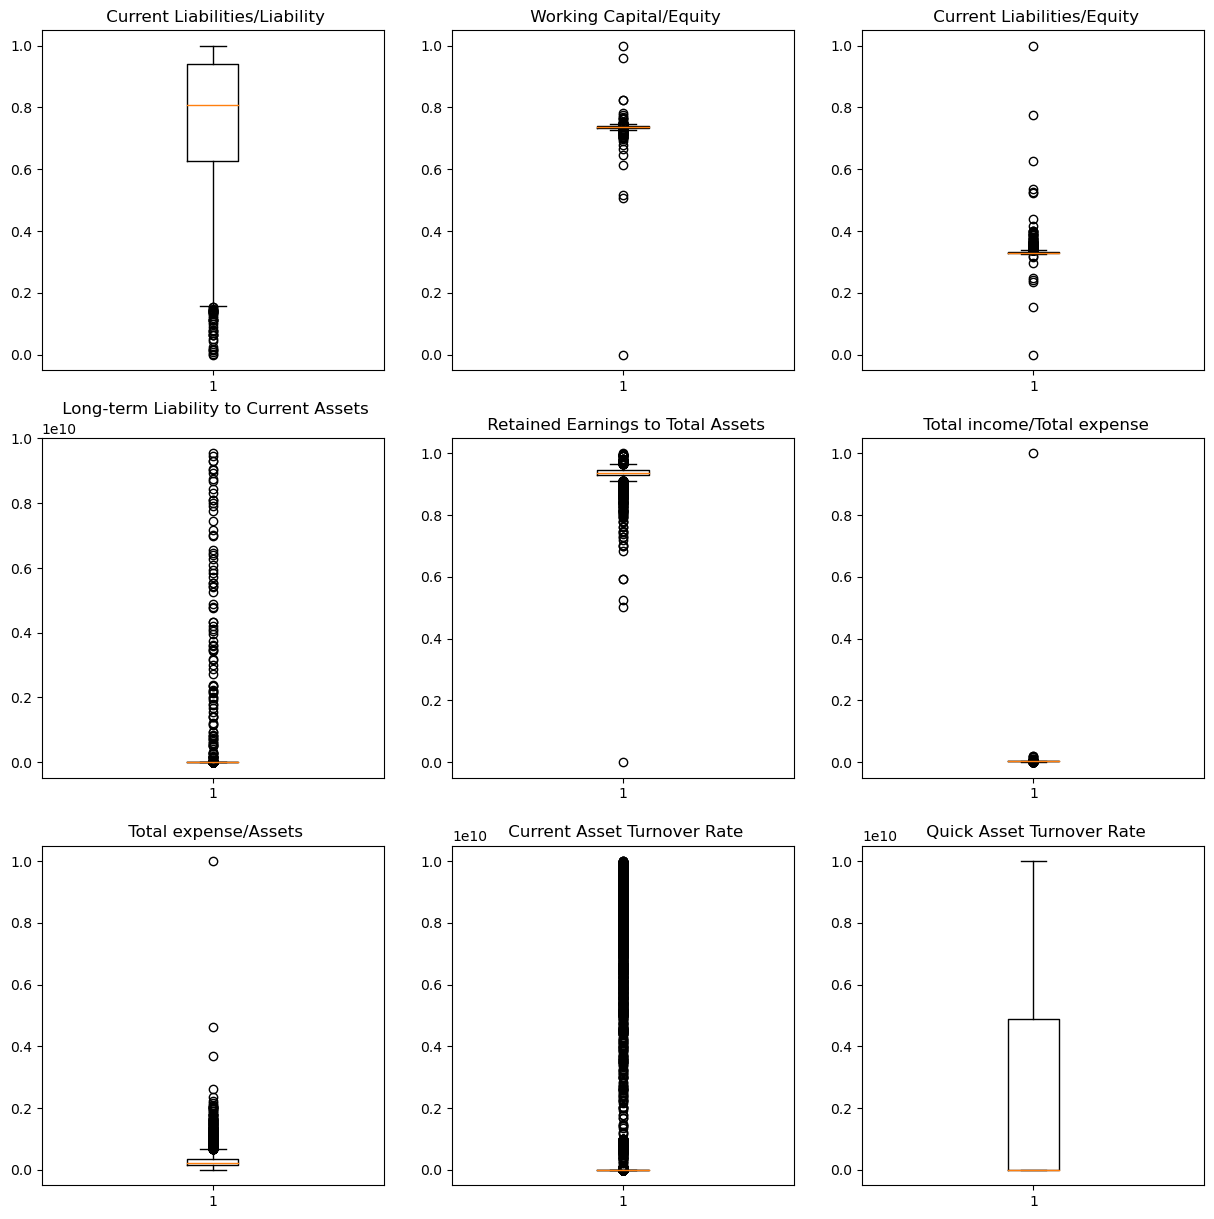

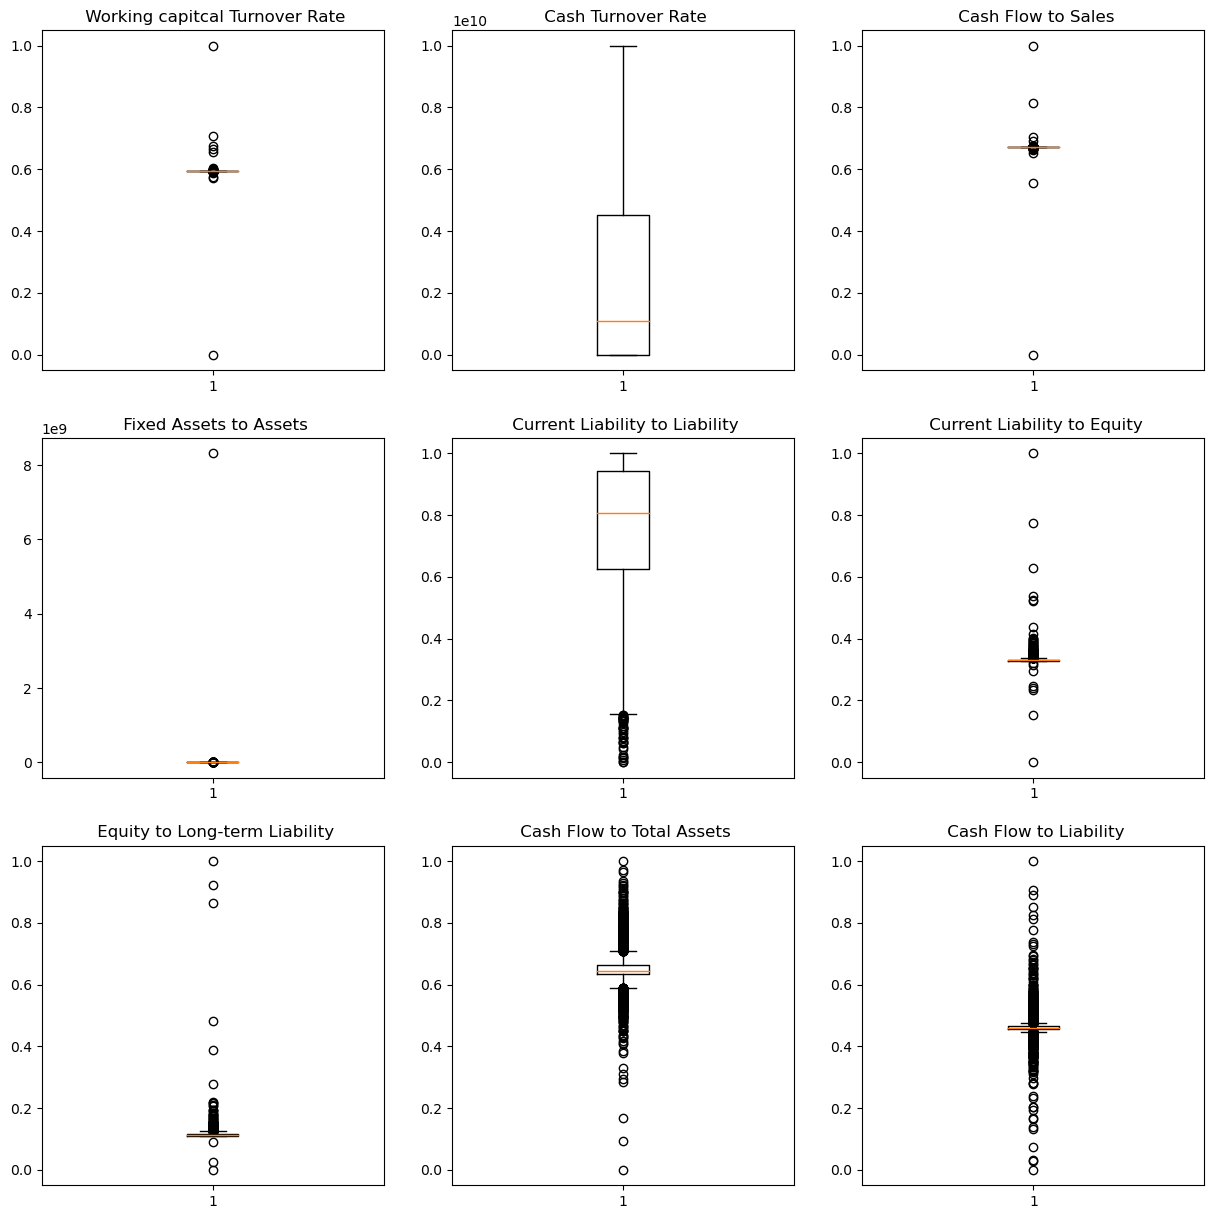

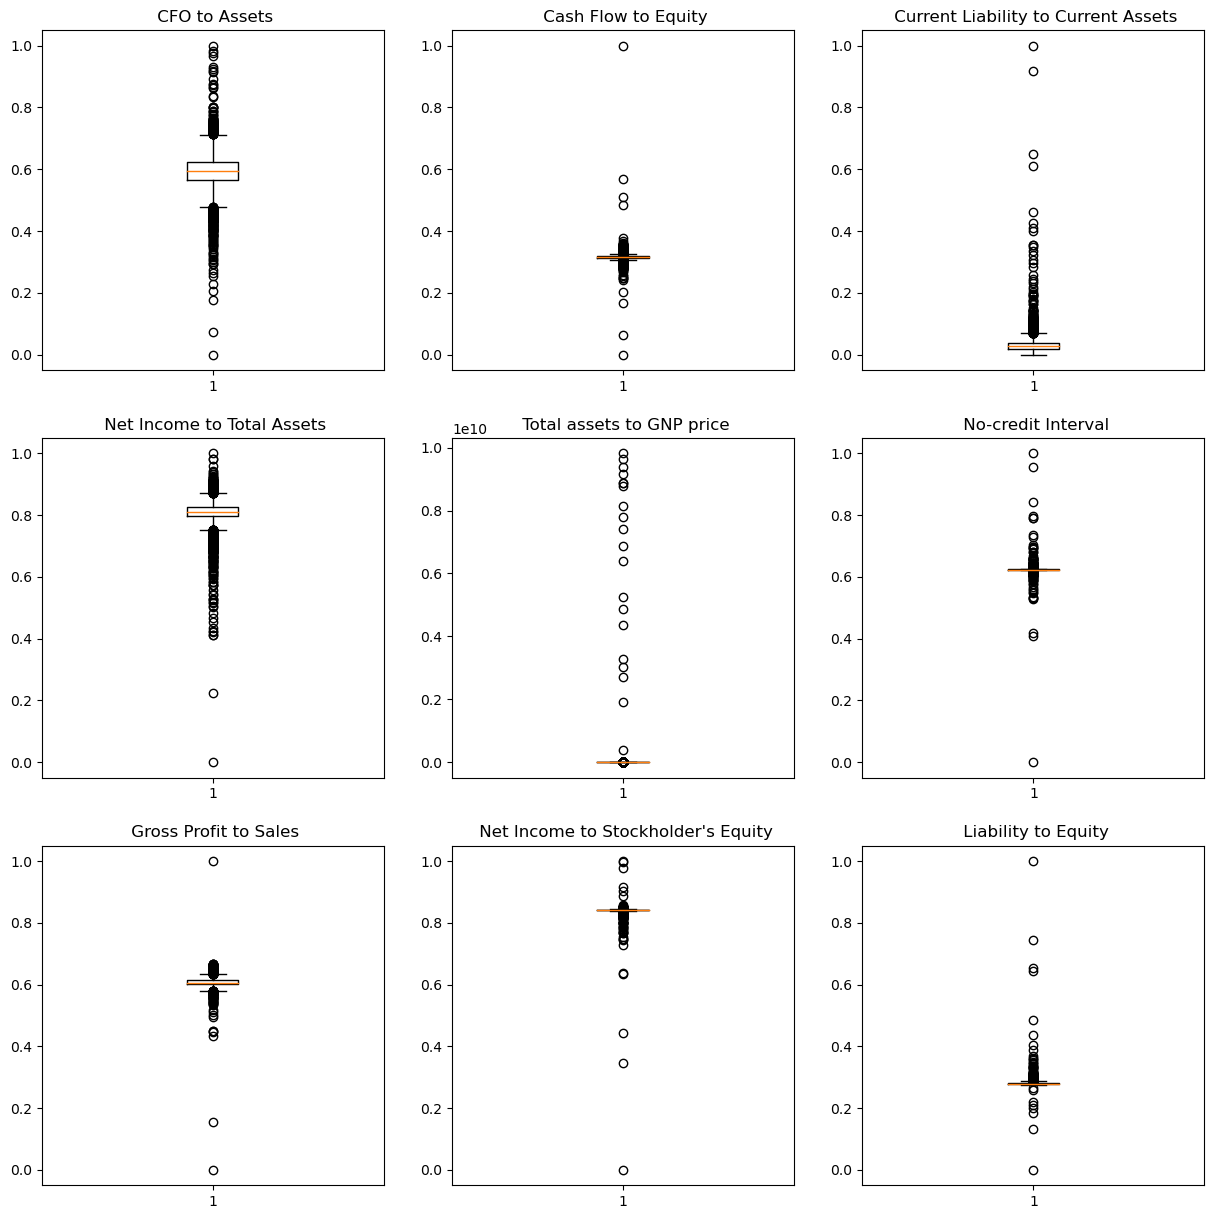

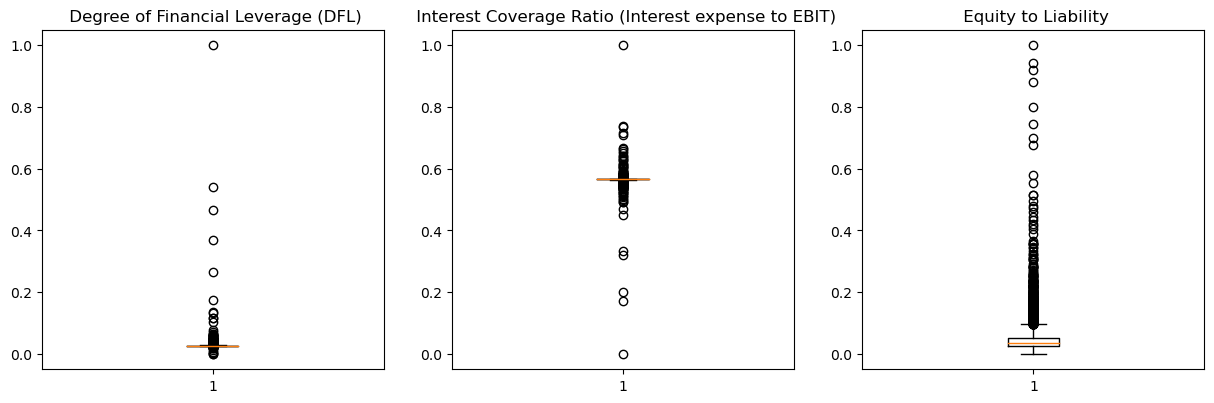

In [18]:
# Number of subplots per figure
n_cols = 3
n_rows = 3

# Loop through variables and create boxplots
for i in range(0, len(num_cols), n_cols * n_rows):
    plt.figure(figsize=(15, 15))
    for j, var in enumerate(num_cols[i:i + n_cols * n_rows]):
        plt.subplot(n_rows, n_cols, j + 1)
        plt.boxplot(df[var])
        plt.title(var)
    plt.show()

## cutting outliers

In [19]:
ratio_win, df_win = Winsorization_Method(df, num_cols, lower=0.03, upper=99.97)
print(f"Ratio of Outliers by Winsorization_Method:{ratio_win}")

Ratio of Outliers by Winsorization_Method:3.12


In [20]:
df_cut, ratio_std, outliers = Standard_Outlier_Remover(df, num_cols, 3)
print(f"Ratio of Outliers by Standard_Outlier_Remover:{ratio_std}")

Ratio of Outliers by Standard_Outlier_Remover:28.01


## correlation 

<Axes: >

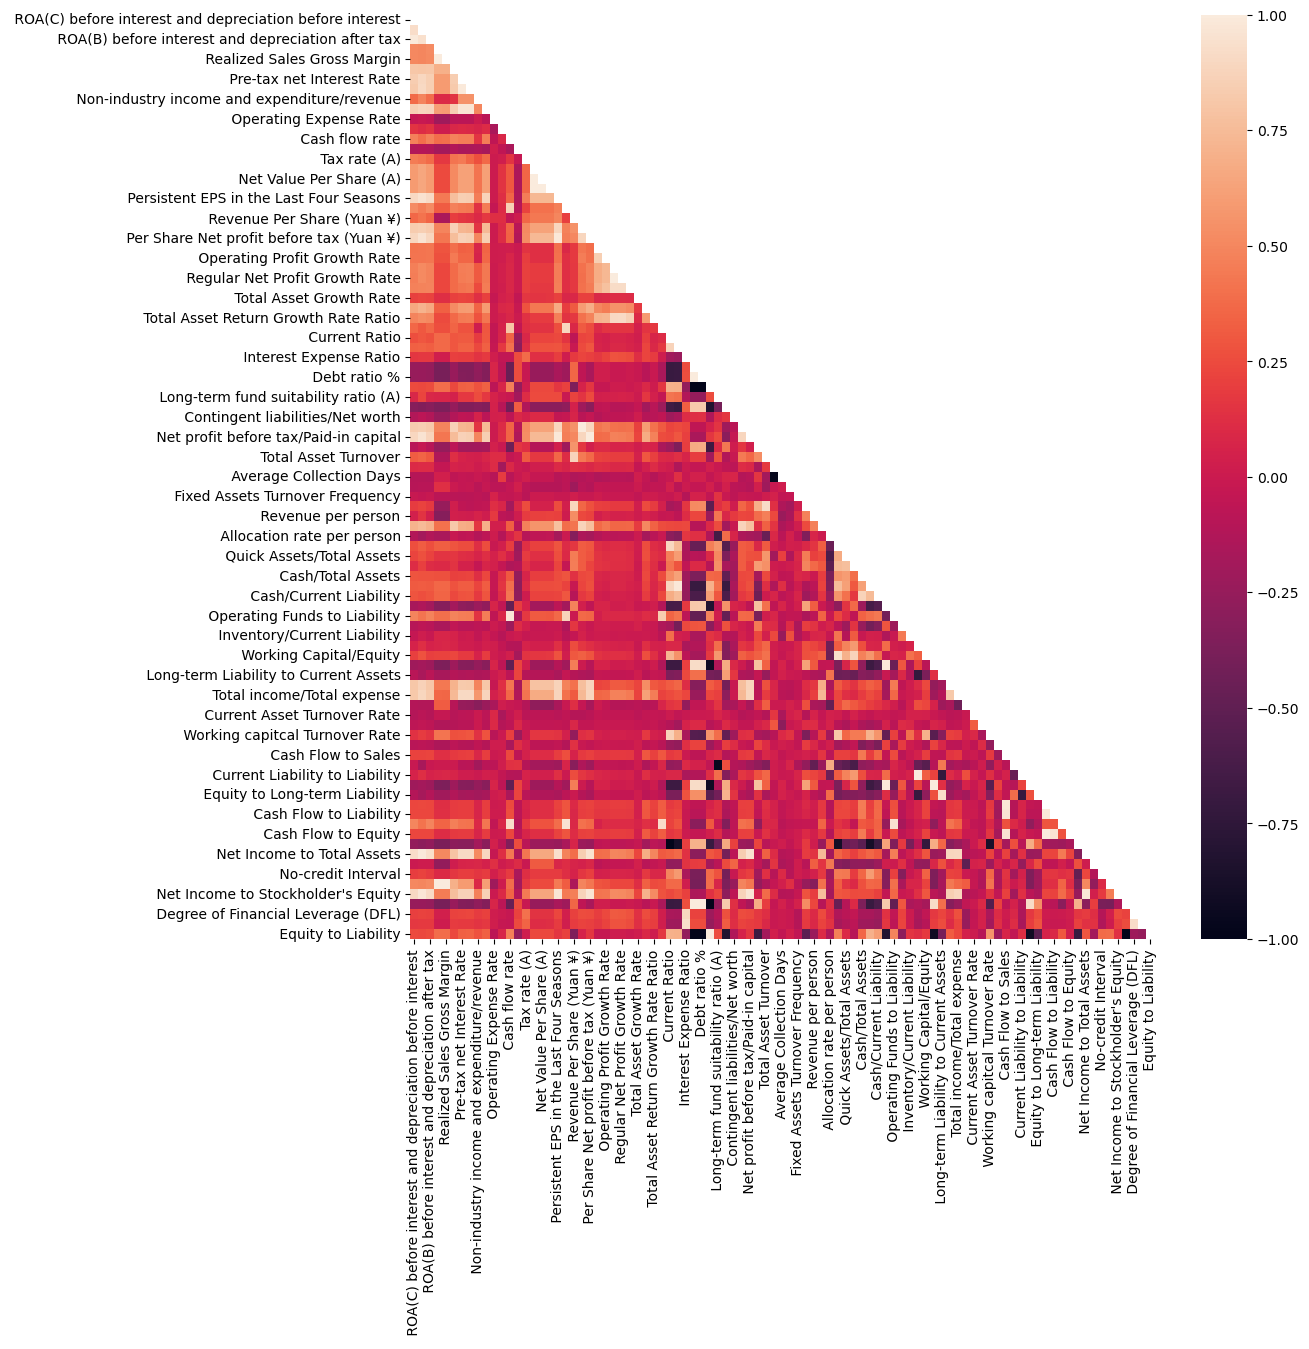

In [21]:
#calculating correlation matrix

corr = df_win.corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask)

In [22]:
#remove highly correlated vavariables 

df_cut = high_corr(df_win)

Removing  ROA(C) before interest and depreciation before interest with 0.95th percentile = -0.27113807823558517
Removing  ROA(B) before interest and depreciation after tax with 0.95th percentile = -0.2732686348344406
Removing  Operating Gross Margin with 0.95th percentile = -0.3869987707707463
Removing  Operating Profit Rate with 0.95th percentile = -0.2601219411670053
Removing  ROA(A) before interest and % after tax with 0.95th percentile = -0.3004606527517078
Removing  Pre-tax net Interest Rate with 0.95th percentile = -0.3377448033750748
Removing  Continuous interest rate (after tax) with 0.95th percentile = -0.33223435946169966
Removing  Net Value Per Share (B) with 0.95th percentile = -0.27993961414849383
Removing  Net Value Per Share (C) with 0.95th percentile = -0.279954282609307
Removing  Persistent EPS in the Last Four Seasons with 0.95th percentile = -0.24682544060479705
Removing  Cash Flow Per Share with 0.95th percentile = -0.21715130534328922
Removing  Operating Profit Per

In [23]:
df_cut.shape

(6606, 39)

In [24]:
cat_cols = df.select_dtypes(include=['int64']).columns[1:]
cat_cols

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [25]:
final_df = pd.concat([df_cut, df[cat_cols], df['Bankrupt?']], axis=1).dropna()
final_df.head()

,Realized Sales Gross Margin,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (A),Realized Sales Gross Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Interest Expense Ratio,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Quick Assets/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Liability-Assets Flag,Net Income Flag,Bankrupt?
0,0.601457,0.302646,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.022102,0.217535,4.980000e+09,0.000327,0.002259,0.629951,0.005024,0.390284,0.006479,0.398036,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.037135,0.166673,1.473360e-04,0.147308,0.276920,0.001036,0.676269,0.025592,0.064856,7.010000e+08,6.550000e+09,4.580000e+08,0.458609,0.716845,0.009219,0.622879,0,1,1
1,0.610235,0.303556,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.022080,0.217620,6.110000e+09,0.000443,0.006016,0.635172,0.005059,0.376760,0.005835,0.397725,0.004917,9.360000e+09,7.190000e+08,0.025484,0.006889,0.012335,0.127236,1.383910e-03,0.056963,0.289642,0.005210,0.308589,0.023947,0.025516,1.065198e-04,7.700000e+09,2.490000e+09,0.459001,0.795297,0.008323,0.623652,0,1,1
2,0.601364,0.302035,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.022760,0.217601,7.280000e+09,0.000396,0.011543,0.629631,0.005100,0.379093,0.006562,0.406580,0.004227,6.500000e+07,2.650000e+09,0.013387,0.028997,0.141016,0.340201,5.340000e+09,0.098162,0.277456,0.013879,0.446027,0.003715,0.021387,1.791094e-03,1.022676e-03,7.610000e+08,0.459254,0.774670,0.040003,0.623841,0,1,1
3,0.583541,0.303350,1.078888e-04,0.0,0.465705,0.000449,0.0,0.154187,0.022046,0.217568,4.880000e+09,0.000382,0.004194,0.630228,0.005047,0.379743,0.005366,0.397925,0.003215,7.130000e+09,9.150000e+09,0.028065,0.015463,0.021320,0.161575,1.010646e-03,0.098715,0.276580,0.003540,0.615848,0.022165,0.024161,8.140000e+09,6.050000e+09,2.030000e+09,0.448518,0.739555,0.003252,0.622929,0,1,1
4,0.598783,0.303475,7.890000e+09,0.0,0.462746,0.000686,0.0,0.167502,0.022096,0.217626,5.510000e+09,0.000439,0.006022,0.636055,0.005303,0.375025,0.006624,0.400079,0.004367,1.633674e-04,2.935211e-04,0.040161,0.058111,0.023988,0.260330,6.804636e-04,0.110195,0.287913,0.004869,0.975007,0.000000,0.026385,6.680000e+09,5.050000e+09,8.240000e+08,0.454411,0.795016,0.003878,0.623521,0,1,1


## train-test split

In [26]:
X_train, X_test, y_train, y_test= train_test_split(final_df.drop("Bankrupt?", axis=1),
                                                   final_df["Bankrupt?"],test_size=0.1, random_state=SEED,
                                                   stratify = final_df["Bankrupt?"])

In [27]:
num_cols_new = df_cut.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[num_cols_new])
X_test_std = scaler.transform(X_test[num_cols_new])

## scaling

In [28]:
X_train_scaled_df = pd.DataFrame(X_train_std, columns=num_cols_new)
X_test_scaled_df = pd.DataFrame(X_test_std, columns=num_cols_new)

# Concatenating scaled and categorical data
X_train_final = pd.concat([X_train_scaled_df, X_train[cat_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

In [29]:
X_test_final.shape

(661, 41)

In [30]:
X_train_final.shape

(5945, 41)

## Synthetic Minority Over-sampling Technique

In [31]:
smote= SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_smote, y_train_smote= smote.fit_resample(X_train_final, y_train)

In [32]:
y_train_smote.value_counts(normalize = True)

Bankrupt?
1    0.5
0    0.5
Name: proportion, dtype: float64

# Model implementation

In [33]:
model = LogisticRegression(random_state=SEED, max_iter = 1000)
model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=23)

## model asessment

In [34]:
model.score(X_train_smote, y_train_smote)

0.8845820326049254

In [35]:
y_pred = model.predict(X_test_final)
probs = model.predict_proba(X_test_final)

In [36]:
accuracy_score(y_test, y_pred)

0.869894099848714

In [37]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'], rownames=['True'])

Prediction,0,1
True,,
0,559,4
1,82,16


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       641
           1       0.16      0.80      0.27        20

    accuracy                           0.87       661
   macro avg       0.58      0.84      0.60       661
weighted avg       0.97      0.87      0.91       661



## tunning

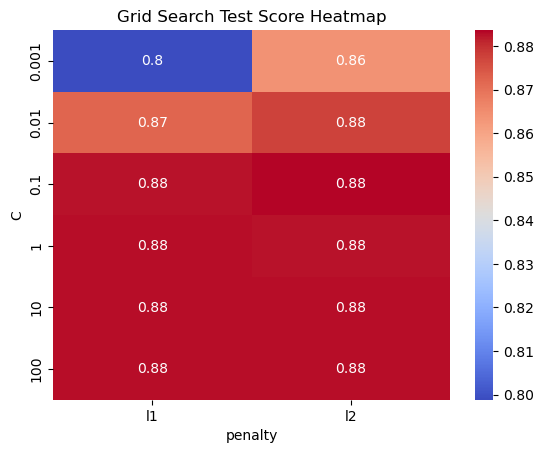

In [39]:
#GridSearch

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# extend regularization by adding l1 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) #cross-validation 
grid_search = GridSearchCV(LogisticRegression(random_state = SEED, max_iter = 1000), param_grid, cv=cv, scoring='accuracy',
                          n_jobs = -1)
grid_search.fit(X_train_smote, y_train_smote)

plot_grid_search(grid_search.cv_results_, ['C', 'penalty'])

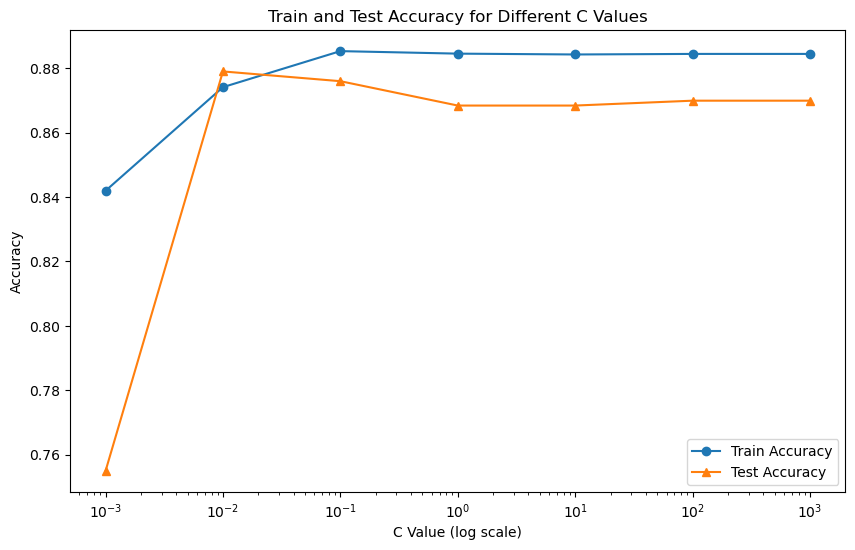

In [40]:
# Test accuracy is higher than train - lets try to improve test accuracy be regularization
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_acc = grid_log_c(X_train_smote, y_train_smote, X_test_final, y_test, C_values)

In [41]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

# Feature importance

## Lasso

In [42]:
# Create a logistic regression object with an L1 penalty
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)

# Fit the model
logistic_l2.fit(X_train_smote, y_train_smote)

# Get the model's performance
print(f"Train accuracy: {logistic_l2.score(X_train_smote, y_train_smote):.3f}")
print(f"Test accuracy: {logistic_l2.score(X_test_final, y_test):.3f}")

Train accuracy: 0.885
Test accuracy: 0.876


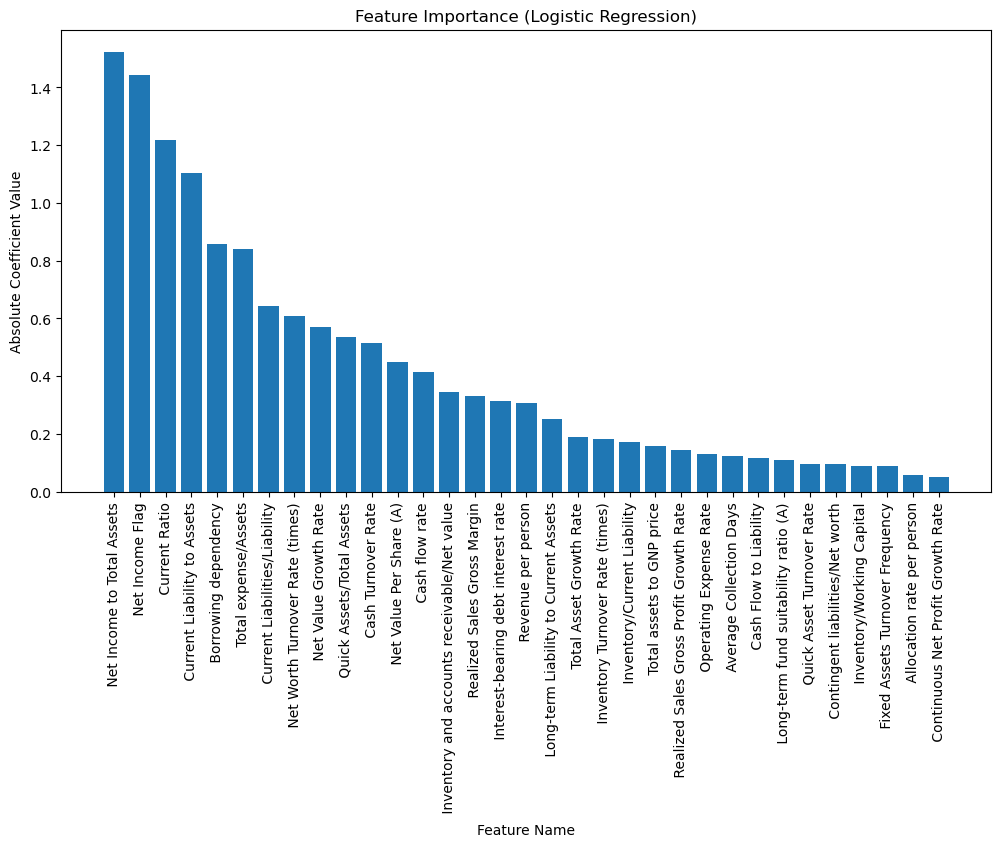

In [43]:
feature_df, low_imp_df = feature_importance_logreg(logistic_l2, cut_off = 0.05)

In [44]:
low_imp_df

,Omitted Feature,Omitted Importance
0,Cash/Current Liability,0.041927
1,Tax rate (A),0.033972
2,Interest Expense Ratio,0.031420
3,Non-industry income and expenditure/revenue,0.024307
4,Current Asset Turnover Rate,0.009048
5,No-credit Interval,0.008318
6,Research and development expense rate,0.004254
7,Liability-Assets Flag,0.000000


In [45]:
#X_train_smote_fe = X_train_smote[list(feature_df['Feature'])[1:]]

## Statmodels

In [46]:
stat_model = sm.Logit(y_train_smote, X_train_smote.iloc[:,:-2])

In [47]:
result = stat_model.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.455071
         Iterations 8


In [48]:
display(result.summary())
accuracy = np.mean(y_pred == y_test)
print('Accuracy:', accuracy)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Bankrupt?   No. Observations:                11532
Model:                          Logit   Df Residuals:                    11493
Method:                           MLE   Df Model:                           38
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                  0.3435
Time:                        23:14:30   Log-Likelihood:                -5247.9
converged:                       True   LL-Null:                       -7993.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
 Realized Sales Gross Margin                    -0.1142      0.043     -2.678      0.007      -0.198      -0.031
 Non-industry income and expenditure/revenue     0.0046      0.030      0.154      0.877      -0.054       0.063
 Operating Expense Rate                         -0.0427      0.028     -1.520      0.128      -0.098       0.012
 Research and development expense rate          -0.0071      0.026     -0.268      0.789      -0.059       0.045
 Cash flow rate                                  0.0774      0.034      2.275      0.023       0.011       0.144
 Interest-bearing debt interest rate            -0.0100      0.029     -0.347      0.729      -0.067       0.047
 Tax rate (A)                                   -0.0453      0.026     -1.729      0.084      -0.097       0.006
 Net Value Per Share (A)                        -0.0018      0.034     -0.053      0.958      -0.069       0.066
 Realized Sales Gross Profit Growth Rate         0.0769      0.024      3.246      0.001       0.030       0.123
 Continuous Net Profit Growth Rate              -0.0305      0.024     -1.287      0.198      -0.077       0.016
 Total Asset Growth Rate                         0.0307      0.027      1.124      0.261      -0.023       0.084
 Net Value Growth Rate                          -0.0200      0.031     -0.651      0.515      -0.080       0.040
 Current Ratio                                  -0.0254      0.041     -0.620      0.535      -0.106       0.055
 Interest Expense Ratio                         -0.0330      0.017     -1.899      0.058      -0.067       0.001
 Long-term fund suitability ratio (A)           -0.0299      0.033     -0.904      0.366      -0.095       0.035
 Borrowing dependency                            1.0794      0.064     16.910      0.000       0.954       1.205
 Contingent liabilities/Net worth               -0.0383      0.040     -0.963      0.336      -0.116       0.040
 Inventory and accounts receivable/Net value    -0.2951      0.057     -5.180      0.000      -0.407      -0.183
 Average Collection Days                        -0.0298      0.033     -0.910      0.363      -0.094       0.034
 Inventory Turnover Rate (times)                -0.0758      0.027     -2.796      0.005      -0.129      -0.023
 Fixed Assets Turnover Frequency                 0.0790      0.026      3.019      0.003       0.028       0.130
 Net Worth Turnover Rate (times)                -0.3640      0.049     -7.451      0.000      -0.460      -0.268
 Revenue per person                              0.0902      0.036      2.527      0.011       0.020       0.160
 Allocation rate per person                      0.0026      0.028      0.091      0.927      -0.053       0.058
 Quick Assets/Total Assets                       0.1211      0.042      2.915      0.004       0.040       0.203
 Cash/Current Liability                          0.0830      0.024      3.522

Accuracy: 0.869894099848714


In [49]:
p_values = result.pvalues
high_pvalues = p_values[p_values > 0.05].index.to_list()
high_pvalues

[' Non-industry income and expenditure/revenue',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Net Value Per Share (A)',
 ' Continuous Net Profit Growth Rate',
 ' Total Asset Growth Rate',
 ' Net Value Growth Rate',
 ' Current Ratio',
 ' Interest Expense Ratio',
 ' Long-term fund suitability ratio (A)',
 ' Contingent liabilities/Net worth',
 ' Average Collection Days',
 ' Allocation rate per person',
 ' Current Liabilities/Liability',
 ' Long-term Liability to Current Assets',
 ' Current Asset Turnover Rate',
 ' Quick Asset Turnover Rate',
 ' Cash Flow to Liability',
 ' Total assets to GNP price',
 ' No-credit Interval']

## Feature selection

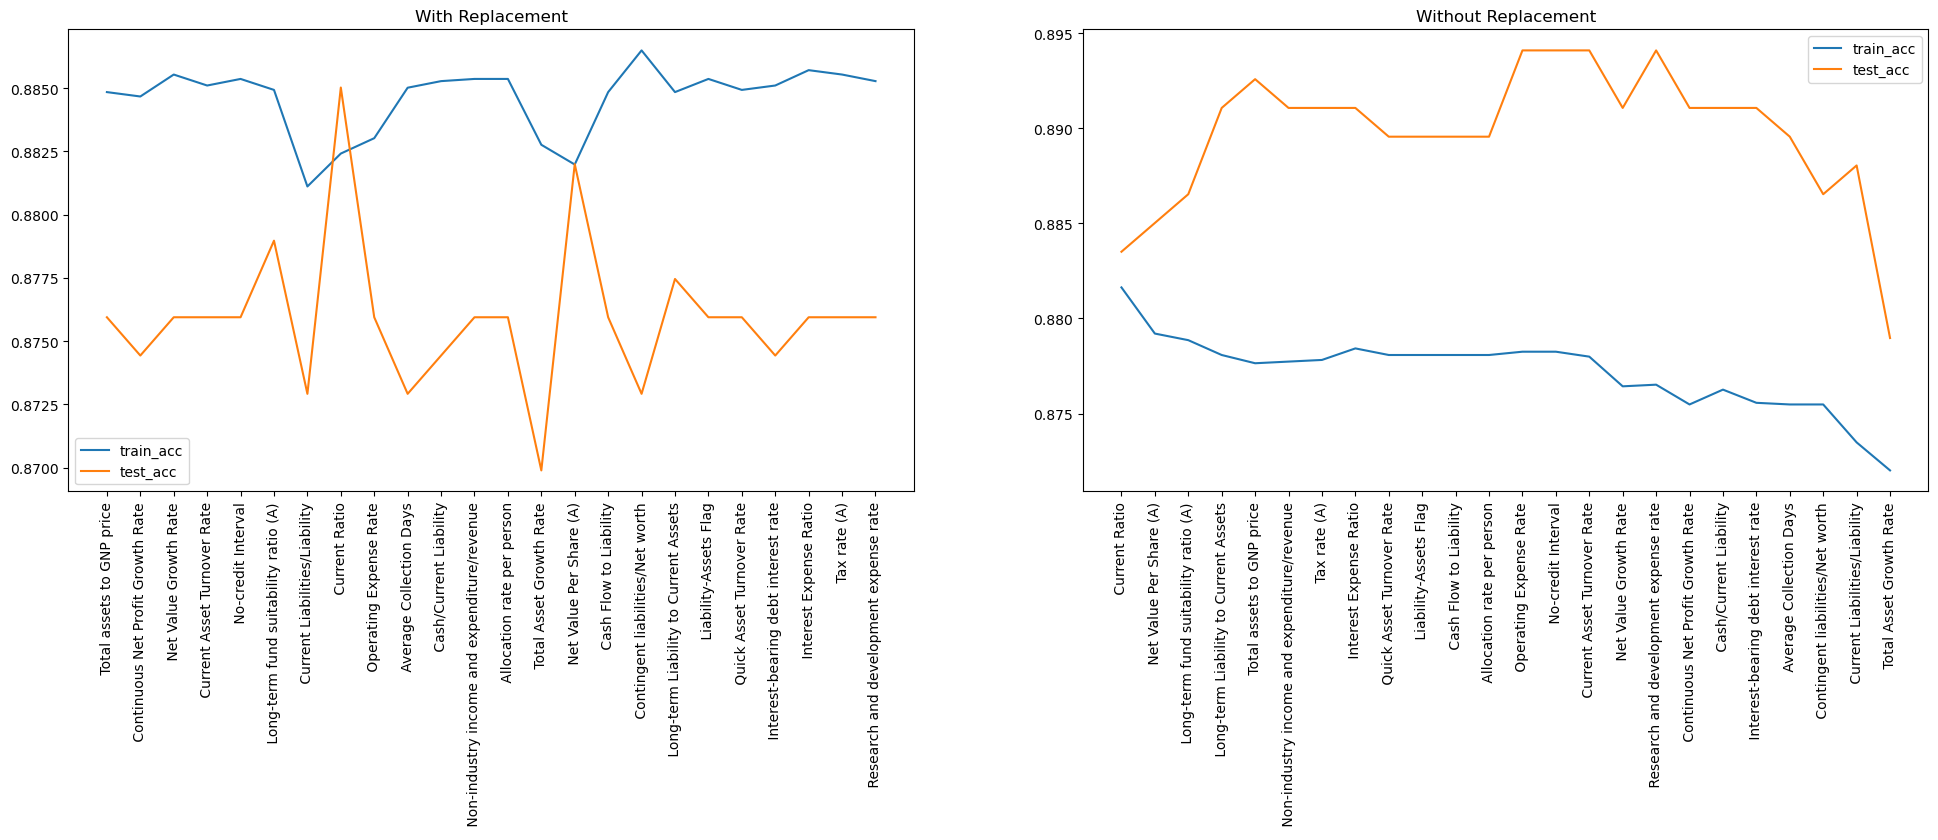

In [50]:
to_delete = set(high_pvalues + low_imp_df['Omitted Feature'].to_list())
acc_df, acc_delete = plot_omitted_accuracy(X_train_smote, y_train_smote, X_test_final, y_test, high_pvalues, low_imp_df, SEED=42)

In [51]:
X_train_fe = X_train_smote.drop(columns = acc_delete)
X_test_fe = X_test_final.drop(columns = acc_delete)

# Final model assessment 

## Implementing the model with final data

In [52]:
# Create a logistic regression object with an L1 penalty
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)

# Fit the model
logistic_l2.fit(X_train_fe, y_train_smote)

#Predict
y_pred = logistic_l2.predict(X_test_fe)

# Get the model's performance
print(f"Train accuracy: {logistic_l2.score(X_train_fe, y_train_smote):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")

Train accuracy: 0.877
Test accuracy: 0.894


In [53]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'], rownames=['True'])

Prediction,0,1
True,,
0,574,3
1,67,17


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       641
           1       0.20      0.85      0.33        20

    accuracy                           0.89       661
   macro avg       0.60      0.87      0.63       661
weighted avg       0.97      0.89      0.92       661



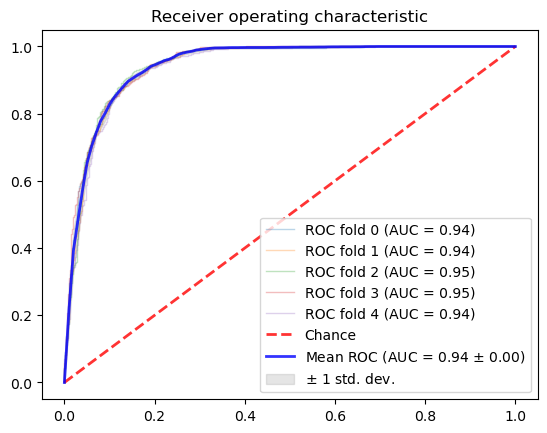

In [55]:
plot_roc(X_train_fe, y_train_smote, logistic_l2, 5)

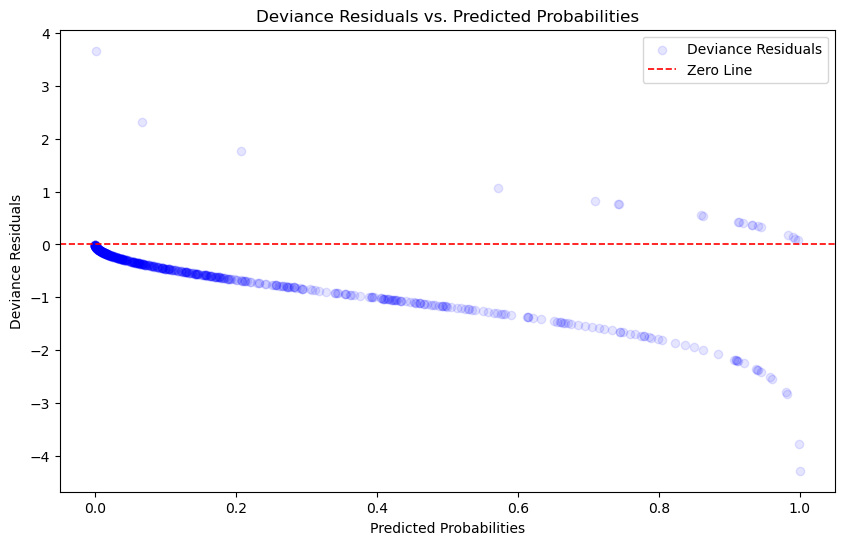

In [56]:
# Predict probabilities
y_pred_prob = logistic_l2.predict_proba(X_test_fe)[:,1]

# Compute deviance residuals
y_log = np.log(y_pred_prob + 1e-15)
nlog = np.log(1 - y_pred_prob + 1e-15)
dev_res = np.sign(y_test - y_pred_prob) * np.sqrt(-2 * (y_test * y_log + (1 - y_test) * nlog))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_prob, dev_res, color='blue', alpha=0.1, label='Deviance Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals vs. Predicted Probabilities')
plt.legend()
plt.show()